In [0]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline 


from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

In [0]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
sample_submit = pd.read_csv("sample_submit.csv")

In [5]:
train.head()

,galactic year,galaxy,existence expectancy index,existence expectancy at birth,Gross income per capita,Income Index,Expected years of education (galactic years),Mean years of education (galactic years),Intergalactic Development Index (IDI),Education Index,"Intergalactic Development Index (IDI), Rank",Population using at least basic drinking-water services (%),Population using at least basic sanitation services (%),Gross capital formation (% of GGP),"Population, total (millions)","Population, urban (%)","Mortality rate, under-five (per 1,000 live births)","Mortality rate, infant (per 1,000 live births)",Old age dependency ratio (old age (65 and older) per 100 creatures (ages 15-64)),"Population, ages 15–64 (millions)","Population, ages 65 and older (millions)","Life expectancy at birth, male (galactic years)","Life expectancy at birth, female (galactic years)","Population, under age 5 (millions)",Young age (0-14) dependency ratio (per 100 creatures ages 15-64),"Adolescent birth rate (births per 1,000 female creatures ages 15-19)",Total unemployment rate (female to male ratio),Vulnerable employment (% of total employment),"Unemployment, total (% of labour force)",Employment in agriculture (% of total employment),Labour force participation rate (% ages 15 and older),"Labour force participation rate (% ages 15 and older), female",Employment in services (% of total employment),"Labour force participation rate (% ages 15 and older), male",Employment to population ratio (% ages 15 and older),Jungle area (% of total land area),"Share of employment in nonagriculture, female (% of total employment in nonagriculture)",Youth unemployment rate (female to male ratio),"Unemployment, youth (% ages 15–24)","Mortality rate, female grown up (per 1,000 people)","Mortality rate, male grown up (per 1,000 people)","Infants lacking immunization, red hot disease (% of one-galactic year-olds)","Infants lacking immunization, Combination Vaccine (% of one-galactic year-olds)",Gross galactic product (GGP) per capita,"Gross galactic product (GGP), total","Outer Galaxies direct investment, net inflows (% of GGP)",Exports and imports (% of GGP),Share of seats in senate (% held by female),Natural resource depletion,"Mean years of education, female (galactic years)","Mean years of education, male (galactic years)","Expected years of education, female (galactic years)","Expected years of education, male (galactic years)","Maternal mortality ratio (deaths per 100,000 live births)",Renewable energy consumption (% of total final energy consumption),"Estimated gross galactic income per capita, male","Estimated gross galactic income per capita, female",Rural population with access to electricity (%),Domestic credit provided by financial sector (% of GGP),"Population with at least some secondary education, female (% ages 25 and older)","Population with at least some secondary education, male (% ages 25 and older)",Gross fixed capital formation (% of GGP),"Remittances, inflows (% of GGP)",Population with at least some secondary education (% ages 25 and older),Intergalactic inbound tourists (thousands),"Gross enrolment ratio, primary (% of primary under-age population)","Respiratory disease incidence (per 100,000 people)",Interstellar phone subscriptions (per 100 people),"Interstellar Data Net users, total (% of population)",Current health expenditure (% of GGP),"Intergalactic Development Index (IDI), female","Intergalactic Development Index (IDI), male",Gender Development Index (GDI),"Intergalactic Development Index (IDI), female, Rank","Intergalactic Development Index (IDI), male, Rank",Adjusted net savings,"Creature Immunodeficiency Disease prevalence, adult (% ages 15-49), total",Private galaxy capital flows (% of GGP),Gender Inequality Index (GII),y
0,990025,Large Magellanic Cloud (LMC),0.628657,63.125200,27109.234310,0.646039,8.240543,NaN,NaN,NaN,NaN,NaN,NaN,38.305483,681.841086,22.131436,150.259290,129.841789,12.403812,490.446400,60.121580,57.028183,69.825369,46

In [0]:
knn_imputer = KNNImputer(n_neighbors=3, weights="distance")
X_df = train.loc[:,~train.columns.isin(['y', 'galaxy'])]
X = knn_imputer.fit_transform(X_df)

In [0]:
X_df = pd.DataFrame(data=X, columns=X_df.columns)
X_df.head()
X_test_df = test.loc[:, ~test.columns.isin(['galaxy'])]
X_test_df = pd.DataFrame(data=knn_imputer.transform(X_test_df), columns=X_test_df.columns)

In [0]:
train.loc[:,~train.columns.isin(['galaxy','y'])] = X_df
test.loc[:,~test.columns.isin(['galaxy'])] = X_test_df

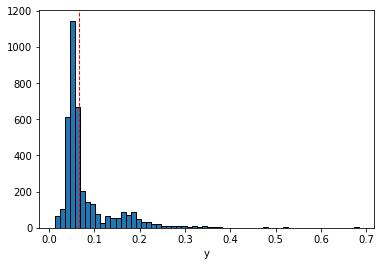

In [9]:
plt.hist(train.y, bins=60, edgecolor='black')
plt.axvline(0.066, color='red', linestyle='dashed', linewidth=1)
plt.xlabel("y")
plt.show();

In [0]:
y_class = (train.y < 0.066).astype(int)

In [11]:
enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(train['galaxy'].values.reshape(-1,1))

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='ignore', sparse=True)

In [12]:
new_data = enc.transform(train['galaxy'].values.reshape(-1,1)).toarray()
new_data.shape
new_data_test = enc.transform(test.galaxy.values.reshape(-1,1)).toarray()
new_data_test.shape

(890, 181)

In [13]:
new_columns_galaxy = enc.get_feature_names(['galaxy'])
len(new_columns_galaxy)

181

### **Clear noise:**

In [0]:
#u, s, vh = np.linalg.svd(train.loc[:,~train.columns.isin(['galaxy', 'y','galactic year'])])

In [0]:
#s = list(s)
#s[-40:] = [0] * 40
#s = np.array(s)

In [0]:
#print(u[:, :77].shape)
#print(np.diag(s).shape)
#print(vh.shape)

(3865, 77)
(77, 77)
(77, 77)


In [0]:
#np.dot(u[:, :77] * s, vh).shape

(3865, 77)

In [0]:
#train.loc[:,~train.columns.isin(['galaxy', 'y','galactic year'])] = np.dot(u[:, :77] * s, vh)

In [0]:
#train.head()

,galactic year,galaxy,existence expectancy index,existence expectancy at birth,Gross income per capita,Income Index,Expected years of education (galactic years),Mean years of education (galactic years),Intergalactic Development Index (IDI),Education Index,"Intergalactic Development Index (IDI), Rank",Population using at least basic drinking-water services (%),Population using at least basic sanitation services (%),Gross capital formation (% of GGP),"Population, total (millions)","Population, urban (%)","Mortality rate, under-five (per 1,000 live births)","Mortality rate, infant (per 1,000 live births)",Old age dependency ratio (old age (65 and older) per 100 creatures (ages 15-64)),"Population, ages 15–64 (millions)","Population, ages 65 and older (millions)","Life expectancy at birth, male (galactic years)","Life expectancy at birth, female (galactic years)","Population, under age 5 (millions)",Young age (0-14) dependency ratio (per 100 creatures ages 15-64),"Adolescent birth rate (births per 1,000 female creatures ages 15-19)",Total unemployment rate (female to male ratio),Vulnerable employment (% of total employment),"Unemployment, total (% of labour force)",Employment in agriculture (% of total employment),Labour force participation rate (% ages 15 and older),"Labour force participation rate (% ages 15 and older), female",Employment in services (% of total employment),"Labour force participation rate (% ages 15 and older), male",Employment to population ratio (% ages 15 and older),Jungle area (% of total land area),"Share of employment in nonagriculture, female (% of total employment in nonagriculture)",Youth unemployment rate (female to male ratio),"Unemployment, youth (% ages 15–24)","Mortality rate, female grown up (per 1,000 people)","Mortality rate, male grown up (per 1,000 people)","Infants lacking immunization, red hot disease (% of one-galactic year-olds)","Infants lacking immunization, Combination Vaccine (% of one-galactic year-olds)",Gross galactic product (GGP) per capita,"Gross galactic product (GGP), total","Outer Galaxies direct investment, net inflows (% of GGP)",Exports and imports (% of GGP),Share of seats in senate (% held by female),Natural resource depletion,"Mean years of education, female (galactic years)","Mean years of education, male (galactic years)","Expected years of education, female (galactic years)","Expected years of education, male (galactic years)","Maternal mortality ratio (deaths per 100,000 live births)",Renewable energy consumption (% of total final energy consumption),"Estimated gross galactic income per capita, male","Estimated gross galactic income per capita, female",Rural population with access to electricity (%),Domestic credit provided by financial sector (% of GGP),"Population with at least some secondary education, female (% ages 25 and older)","Population with at least some secondary education, male (% ages 25 and older)",Gross fixed capital formation (% of GGP),"Remittances, inflows (% of GGP)",Population with at least some secondary education (% ages 25 and older),Intergalactic inbound tourists (thousands),"Gross enrolment ratio, primary (% of primary under-age population)","Respiratory disease incidence (per 100,000 people)",Interstellar phone subscriptions (per 100 people),"Interstellar Data Net users, total (% of population)",Current health expenditure (% of GGP),"Intergalactic Development Index (IDI), female","Intergalactic Development Index (IDI), male",Gender Development Index (GDI),"Intergalactic Development Index (IDI), female, Rank","Intergalactic Development Index (IDI), male, Rank",Adjusted net savings,"Creature Immunodeficiency Disease prevalence, adult (% ages 15-49), total",Private galaxy capital flows (% of GGP),Gender Inequality Index (GII),y
0,990025.0,Large Magellanic Cloud (LMC),0.772257,69.066463,27109.230433,0.758696,12.675697,10.300169,0.748309,0.698669,86.826840,90.476220,76.096035,30.109520,681.840435,26.974965,155.985533,113.776745,12.106010,490.47

In [0]:
#np.max(train['existence expectancy index'])

1.1824219331142454

In [0]:
train['y_class'] = y_class
train = train.join(pd.DataFrame(data=new_data, index=train.index, columns=new_columns_galaxy))
test = test.join(pd.DataFrame(data=new_data_test, index=test.index, columns=new_columns_galaxy))

In [15]:
train.head()

,galactic year,galaxy,existence expectancy index,existence expectancy at birth,Gross income per capita,Income Index,Expected years of education (galactic years),Mean years of education (galactic years),Intergalactic Development Index (IDI),Education Index,"Intergalactic Development Index (IDI), Rank",Population using at least basic drinking-water services (%),Population using at least basic sanitation services (%),Gross capital formation (% of GGP),"Population, total (millions)","Population, urban (%)","Mortality rate, under-five (per 1,000 live births)","Mortality rate, infant (per 1,000 live births)",Old age dependency ratio (old age (65 and older) per 100 creatures (ages 15-64)),"Population, ages 15–64 (millions)","Population, ages 65 and older (millions)","Life expectancy at birth, male (galactic years)","Life expectancy at birth, female (galactic years)","Population, under age 5 (millions)",Young age (0-14) dependency ratio (per 100 creatures ages 15-64),"Adolescent birth rate (births per 1,000 female creatures ages 15-19)",Total unemployment rate (female to male ratio),Vulnerable employment (% of total employment),"Unemployment, total (% of labour force)",Employment in agriculture (% of total employment),Labour force participation rate (% ages 15 and older),"Labour force participation rate (% ages 15 and older), female",Employment in services (% of total employment),"Labour force participation rate (% ages 15 and older), male",Employment to population ratio (% ages 15 and older),Jungle area (% of total land area),"Share of employment in nonagriculture, female (% of total employment in nonagriculture)",Youth unemployment rate (female to male ratio),"Unemployment, youth (% ages 15–24)","Mortality rate, female grown up (per 1,000 people)",...,galaxy_Reticulum II,galaxy_Reticulum III,galaxy_Sagittarius Dwarf Irregular Galaxy (SagDIG),galaxy_Sagittarius Dwarf Sphr SagDEG,galaxy_Sagittarius II,galaxy_Sculptor Dwarf (E351-G30),galaxy_Segue 1,galaxy_Segue 2,"galaxy_Sextans A (92205, DDO 75)",galaxy_Sextans B (UGC 5373),galaxy_Sextans Dwarf Sph,"galaxy_Small Magellanic Cloud (SMC, NGC 292)",galaxy_Triangulum Galaxy (M33),galaxy_Triangulum II,galaxy_Tucana Dwarf,galaxy_Tucana II,galaxy_Tucana III,galaxy_Tucana IV,galaxy_UGC 4483,galaxy_UGC 4879 (VV124)[61],galaxy_UGC 7577 (DDO 125),galaxy_UGC 8508 (I Zw 060),galaxy_UGC 8651 (DDO 181),galaxy_UGC 8833,galaxy_UGC 9128 (DDO 187),galaxy_UGC 9240 (DDO 190),galaxy_UGCA 105,galaxy_UGCA 133 (DDO 44),galaxy_UGCA 15 (DDO 6),galaxy_UGCA 276 (DDO 113),galaxy_UGCA 292,galaxy_UGCA 438 (ESO 407-018),galaxy_UGCA 86,galaxy_UGCA 92,galaxy_Ursa Major I Dwarf (UMa I dSph),galaxy_Ursa Major II Dwarf,galaxy_Ursa Minor Dwarf,galaxy_Virgo I,galaxy_Willman 1,"galaxy_Wolf-Lundmark-Melotte (WLM, DDO 221)"
0,990025.0,Large Magellanic Cloud (LMC),0.628657,63.125200,27109.234310,0.646039,8.240543,13.325463,0.888222,0.768955,85.316816,84.353852,78.213431,38.305483,681.841086,22.131436,150.259290,129.841789,12.403812,490.446400,60.121580,57.028183,69.825369,46.018230,98.216072,174.617899,2.409448,47.131287,9.455120,51.890786,79.614066,73.071600,63.770239,85.851544,71.266467,73.166354,52.770523,2.408014,23.178778,431.270303,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,990025.0,Camelopardalis B,0.818082,81.004994,30166.793958,0.852246,10.671823,4.742470,0.833624,0.467873,152.522198,114.794958,116.785412,36.255559,423.973089,89.294181,117.069332,61.822590,13.054898,560.547706,58.573002,69.873905,76.752305,40.167960,88.322574,109.892385,2.135966,63.290081,15.992775,46.200242,63.813720,45.482071,65.293896,93.526359,69.905912,35.590371,53.690605,2.080654,32.291273,221.411013,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,990025.0,Virgo I,0.659443,59.570534,8441.707353,0.499762,8.8403

In [16]:
test.head()

,galactic year,galaxy,existence expectancy index,existence expectancy at birth,Gross income per capita,Income Index,Expected years of education (galactic years),Mean years of education (galactic years),Intergalactic Development Index (IDI),Education Index,"Intergalactic Development Index (IDI), Rank",Population using at least basic drinking-water services (%),Population using at least basic sanitation services (%),Gross capital formation (% of GGP),"Population, total (millions)","Population, urban (%)","Mortality rate, under-five (per 1,000 live births)","Mortality rate, infant (per 1,000 live births)",Old age dependency ratio (old age (65 and older) per 100 creatures (ages 15-64)),"Population, ages 15–64 (millions)","Population, ages 65 and older (millions)","Life expectancy at birth, male (galactic years)","Life expectancy at birth, female (galactic years)","Population, under age 5 (millions)",Young age (0-14) dependency ratio (per 100 creatures ages 15-64),"Adolescent birth rate (births per 1,000 female creatures ages 15-19)",Total unemployment rate (female to male ratio),Vulnerable employment (% of total employment),"Unemployment, total (% of labour force)",Employment in agriculture (% of total employment),Labour force participation rate (% ages 15 and older),"Labour force participation rate (% ages 15 and older), female",Employment in services (% of total employment),"Labour force participation rate (% ages 15 and older), male",Employment to population ratio (% ages 15 and older),Jungle area (% of total land area),"Share of employment in nonagriculture, female (% of total employment in nonagriculture)",Youth unemployment rate (female to male ratio),"Unemployment, youth (% ages 15–24)","Mortality rate, female grown up (per 1,000 people)",...,galaxy_Reticulum II,galaxy_Reticulum III,galaxy_Sagittarius Dwarf Irregular Galaxy (SagDIG),galaxy_Sagittarius Dwarf Sphr SagDEG,galaxy_Sagittarius II,galaxy_Sculptor Dwarf (E351-G30),galaxy_Segue 1,galaxy_Segue 2,"galaxy_Sextans A (92205, DDO 75)",galaxy_Sextans B (UGC 5373),galaxy_Sextans Dwarf Sph,"galaxy_Small Magellanic Cloud (SMC, NGC 292)",galaxy_Triangulum Galaxy (M33),galaxy_Triangulum II,galaxy_Tucana Dwarf,galaxy_Tucana II,galaxy_Tucana III,galaxy_Tucana IV,galaxy_UGC 4483,galaxy_UGC 4879 (VV124)[61],galaxy_UGC 7577 (DDO 125),galaxy_UGC 8508 (I Zw 060),galaxy_UGC 8651 (DDO 181),galaxy_UGC 8833,galaxy_UGC 9128 (DDO 187),galaxy_UGC 9240 (DDO 190),galaxy_UGCA 105,galaxy_UGCA 133 (DDO 44),galaxy_UGCA 15 (DDO 6),galaxy_UGCA 276 (DDO 113),galaxy_UGCA 292,galaxy_UGCA 438 (ESO 407-018),galaxy_UGCA 86,galaxy_UGCA 92,galaxy_Ursa Major I Dwarf (UMa I dSph),galaxy_Ursa Major II Dwarf,galaxy_Ursa Minor Dwarf,galaxy_Virgo I,galaxy_Willman 1,"galaxy_Wolf-Lundmark-Melotte (WLM, DDO 221)"
0,1007012.0,KK98 77,0.456086,51.562543,12236.576447,0.593325,10.414164,10.699072,0.547114,0.556267,232.621842,105.193088,64.241392,17.418350,853.584006,56.153173,114.492035,88.839594,13.724837,522.766688,79.945460,72.331385,74.406636,88.125679,84.757820,118.132219,2.678913,93.508600,11.101943,63.260490,77.877212,64.149943,55.523753,87.092695,73.117592,40.216530,46.897833,2.258852,22.499069,278.021980,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1007012.0,Reticulum III,0.529835,57.228262,3431.883825,0.675407,7.239485,5.311122,0.497688,0.409969,247.580771,55.730638,46.217440,33.027886,522.306874,32.654232,140.555915,87.202590,12.830114,354.763876,44.247382,66.754833,70.848793,96.646152,102.313064,131.796609,2.628505,104.310348,10.948053,92.188123,90.356123,93.114615,38.387258,92.914963,87.012683,33.618655,54.211814,2.553305,19.112398,428.715027,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1008016.0,Reticulum III,0.560976,59.379539,27562.914252,0.594624,11.774890,5.937797,

In [0]:
del train['galaxy']
del test['galaxy']

### 1. Classification

In [0]:
not_class_features = ['y','y_class']
log_reg = LogisticRegression(random_state=10,
                             max_iter=100,
                             solver='liblinear').fit(train.loc[:,train.columns.isin(list(new_columns_galaxy))], train.y_class)

In [19]:
log_reg.score(train.loc[:,train.columns.isin(list(new_columns_galaxy))], train.y_class)

0.9689521345407504

In [0]:
y_class_proba_test = log_reg.predict_proba(test.loc[:,test.columns.isin(list(new_columns_galaxy))])

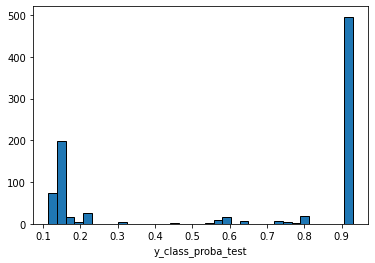

In [21]:
plt.hist(y_class_proba_test[:,1], bins=35, edgecolor='black')
plt.xlabel("y_class_proba_test")
plt.show();

In [0]:
test['y_class_proba_test'] = y_class_proba_test[:,1]

### 2. Prediction

In [0]:
features = train.columns[~train.columns.isin(['y', 'y_class','galaxy', 'y_class_proba_test'])]
lin_reg = LinearRegression()

In [24]:
lin_reg.fit(train[features], train.y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [25]:
print("R2 =", lin_reg.score(train[features], train.y))

R2 = 0.9494477860303557


In [0]:
test['y_pred'] = lin_reg.predict(test[features])

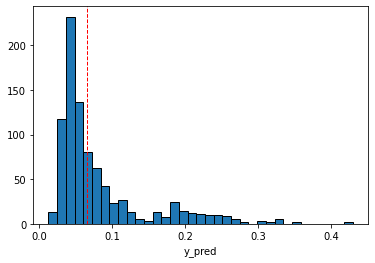

In [0]:
plt.hist(test['y_pred'], bins=35, edgecolor='black')
plt.axvline(0.066, color='red', linestyle='dashed', linewidth=1)
plt.xlabel('y_pred')
plt.show()

### 2.1 Prediction

In [0]:
from pandas import set_option
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

In [0]:
X =  train.loc[:,~train.columns.isin(['y'])]
Y = train['y']
X_train, X_test, y_train, y_test =train_test_split(X,Y,
                                                   test_size=0.25,
                                                   random_state=0)

In [0]:
def GetBasedModel():
    basedModels = []
    basedModels.append(('LR'   , LinearRegression()))
    basedModels.append(('KNN'  , KNeighborsRegressor()))
    basedModels.append(('CART' , DecisionTreeRegressor()))
    basedModels.append(('SVM'  , SVR()))
    basedModels.append(('AB'   , AdaBoostRegressor()))
    basedModels.append(('GBM'  , GradientBoostingRegressor()))
    basedModels.append(('RF'   , RandomForestRegressor()))
    basedModels.append(('ET'   , ExtraTreesRegressor()))

    
    return basedModels

In [0]:
def BasedLine2(X_train, y_train,models):
    # Test options and evaluation metric
    num_folds = 5
    scoring = 'neg_root_mean_squared_error'

    results = []
    names = []
    for name, model in models:
        kfold = KFold(n_splits=num_folds)
        cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
        
    return names, results

In [0]:
class PlotBoxR(object):
    
    
    def __Trace(self,nameOfFeature,value): 
    
        trace = go.Box(
            y=value,
            name = nameOfFeature,
            marker = dict(
                color = 'rgb(0, 128, 128)',
            )
        )
        return trace

    def PlotResult(self,names,results):
        
        data = []

        for i in range(len(names)):
            data.append(self.__Trace(names[i],results[i]))


        py.iplot(data)

In [0]:
models = GetBasedModel()
names,results = BasedLine2(X_train, y_train,models)

In [0]:
def ScoreDataFrame(names,results):
    def floatingDecimals(f_val, dec=3):
        prc = "{:."+str(dec)+"f}" 
    
        return float(prc.format(f_val))

    scores = []
    for r in results:
        scores.append(floatingDecimals(r.mean(),4))

    scoreDataFrame = pd.DataFrame({'Model':names, 'Score': scores})
    return scoreDataFrame

In [46]:
basedLineScore = ScoreDataFrame(names,results)
basedLineScore

,Model,Score
0,LR,-0.0127
1,KNN,-0.0422
2,CART,-0.0255
3,SVM,-0.0763
4,AB,-0.0343
5,GBM,-0.0168
6,RF,-0.0185
7,ET,-0.0132


In [0]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler


def GetScaledModel(nameOfScaler):
    
    if nameOfScaler == 'standard':
        scaler = StandardScaler()
    elif nameOfScaler =='minmax':
        scaler = MinMaxScaler()

    pipelines = []
    pipelines.append((nameOfScaler+'LR'  , Pipeline([('Scaler', scaler),('LR'  , LinearRegression())])))
    pipelines.append((nameOfScaler+'KNN' , Pipeline([('Scaler', scaler),('KNN' , KNeighborsRegressor())])))
    pipelines.append((nameOfScaler+'CART', Pipeline([('Scaler', scaler),('CART', DecisionTreeRegressor())])))
    pipelines.append((nameOfScaler+'SVM' , Pipeline([('Scaler', scaler),('SVM' , SVR())])))
    pipelines.append((nameOfScaler+'AB'  , Pipeline([('Scaler', scaler),('AB'  , AdaBoostRegressor())])  ))
    pipelines.append((nameOfScaler+'GBM' , Pipeline([('Scaler', scaler),('GMB' , GradientBoostingRegressor())])  ))
    pipelines.append((nameOfScaler+'RF'  , Pipeline([('Scaler', scaler),('RF'  , RandomForestRegressor())])  ))
    pipelines.append((nameOfScaler+'ET'  , Pipeline([('Scaler', scaler),('ET'  , ExtraTreesRegressor())])  ))


    return pipelines

In [49]:
models = GetScaledModel('standard')
names,results = BasedLine2(X_train, y_train,models)

scaledScoreStandard = ScoreDataFrame(names,results)
compareModels = pd.concat([basedLineScore,
                           scaledScoreStandard], axis=1)
compareModels

standardLR: -0.012691 (0.001185)
standardKNN: -0.012559 (0.001857)
standardCART: -0.025442 (0.002486)
standardSVM: -0.070462 (0.000989)
standardAB: -0.033671 (0.002578)
standardGBM: -0.016848 (0.001389)
standardRF: -0.018349 (0.001120)
standardET: -0.013413 (0.001339)


,Model,Score,Model,Score
0,LR,-0.0127,standardLR,-0.0127
1,KNN,-0.0422,standardKNN,-0.0126
2,CART,-0.0255,standardCART,-0.0254
3,SVM,-0.0763,standardSVM,-0.0705
4,AB,-0.0343,standardAB,-0.0337
5,GBM,-0.0168,standardGBM,-0.0168
6,RF,-0.0185,standardRF,-0.0183
7,ET,-0.0132,standardET,-0.0134


In [50]:
models = GetScaledModel('minmax')
names,results = BasedLine2(X_train, y_train,models)

scaledScoreMinMax = ScoreDataFrame(names,results)
compareModels = pd.concat([basedLineScore,
                           scaledScoreStandard,
                          scaledScoreMinMax], axis=1)
compareModels

minmaxLR: -0.012691 (0.001185)
minmaxKNN: -0.011647 (0.001658)
minmaxCART: -0.024878 (0.003049)
minmaxSVM: -0.044101 (0.002383)
minmaxAB: -0.031729 (0.001839)
minmaxGBM: -0.016759 (0.001402)
minmaxRF: -0.018402 (0.001060)
minmaxET: -0.013309 (0.001359)


,Model,Score,Model,Score,Model,Score
0,LR,-0.0127,standardLR,-0.0127,minmaxLR,-0.0127
1,KNN,-0.0422,standardKNN,-0.0126,minmaxKNN,-0.0116
2,CART,-0.0255,standardCART,-0.0254,minmaxCART,-0.0249
3,SVM,-0.0763,standardSVM,-0.0705,minmaxSVM,-0.0441
4,AB,-0.0343,standardAB,-0.0337,minmaxAB,-0.0317
5,GBM,-0.0168,standardGBM,-0.0168,minmaxGBM,-0.0168
6,RF,-0.0185,standardRF,-0.0183,minmaxRF,-0.0184
7,ET,-0.0132,standardET,-0.0134,minmaxET,-0.0133


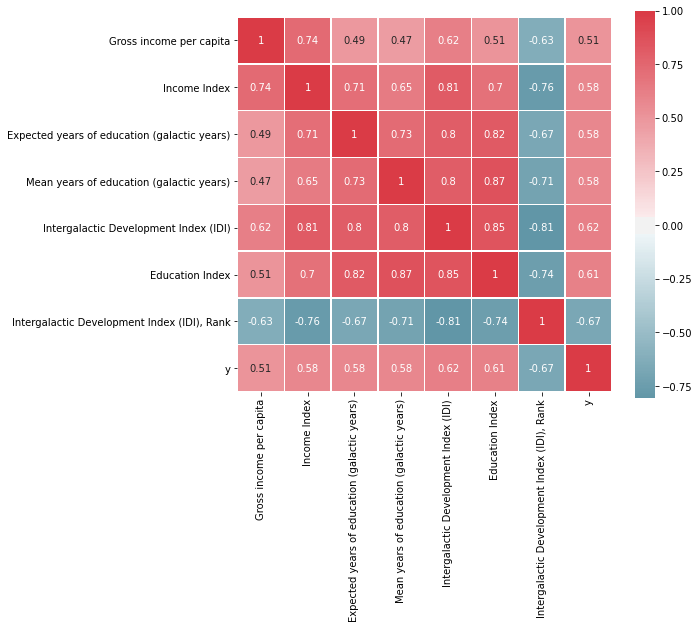

In [63]:
import seaborn as sns

def HeatMap(df,x=True):
        correlations = df.corr()
        ## Create color map ranging between two colors
        cmap = sns.diverging_palette(220, 10, as_cmap=True)
        fig, ax = plt.subplots(figsize=(10, 10))
        fig = sns.heatmap(correlations, cmap=cmap, vmax=1.0, center=0,square=True, linewidths=.5, annot=x, cbar_kws={"shrink": .75})
        fig.set_xticklabels(fig.get_xticklabels(), rotation = 90, fontsize = 10)
        fig.set_yticklabels(fig.get_yticklabels(), rotation = 0, fontsize = 10)
        plt.tight_layout()
        plt.show()

HeatMap(train[list(train.columns[3:10]) + ['y']],x=True)

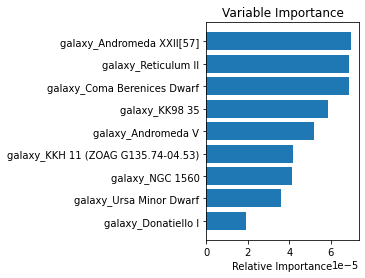

In [71]:
clf = ExtraTreesRegressor(n_estimators=250,
                              random_state=10)

clf.fit(X_train, y_train)

# #############################################################################
# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos[1:10], feature_importance[sorted_idx[1:10]], align='center')
plt.yticks(pos[1:10], train.columns[sorted_idx[1:10]])#boston.feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [0]:
### Tuning

In [0]:
df_unscaled = train.loc[:,~train.columns.isin(['y', 'y_class'])]
df_imp_scaled_name = df_unscaled.columns

In [84]:
df_corr = pd.DataFrame(data=train.corrwith(train.y), columns=['corr'])
df_corr['abs_corr'] = np.abs(df_corr['corr'])
df_corr.sort_values(by='abs_corr', ascending=False).head(30)

,corr,abs_corr
y,1.000000,1.000000
y_class,-0.679365,0.679365
"Intergalactic Development Index (IDI), Rank",-0.668840,0.668840
Gender Inequality Index (GII),-0.654510,0.654510
Intergalactic Development Index (IDI),0.618800,0.618800
"Intergalactic Development Index (IDI), male, Rank",-0.613233,0.613233
Education Index,0.607597,0.607597
"Intergalactic Development Index (IDI), female, Rank",-0.603504,0.603504
Old age dependency ratio (old age (65 and older) per 100 creatures (ages 15-64)),0.596061,0.596061
"Intergalactic Development Index (IDI), male",0.589894,0.589894


(array([177.,  25.,   7.,   9.,  15.,  20.,   7.,   0.,   0.,   1.]),
 array([5.43451997e-04, 1.00489107e-01, 2.00434762e-01, 3.00380416e-01,
        4.00326071e-01, 5.00271726e-01, 6.00217381e-01, 7.00163036e-01,
        8.00108690e-01, 9.00054345e-01, 1.00000000e+00]),
 <a list of 10 Patch objects>)

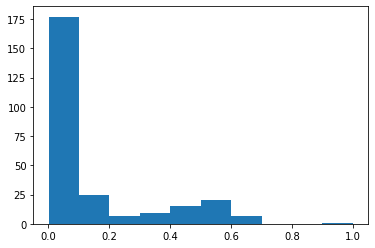

In [136]:
plt.hist(df_corr['abs_corr'])

In [137]:
corrs = [ai for ai, bi in list(zip(df_corr.index, df_corr.abs_corr)) if bi >= 0.4 and ai !='y' and ai != 'y_class']
corrs
galaxy_cols = [x for x in train.columns if x.startswith('galaxy')]
galaxy_cols[:10]

['galaxy_Andromeda Galaxy (M31)',
 'galaxy_Andromeda I',
 'galaxy_Andromeda II',
 'galaxy_Andromeda III',
 'galaxy_Andromeda IX',
 'galaxy_Andromeda V',
 'galaxy_Andromeda VIII',
 'galaxy_Andromeda X',
 'galaxy_Andromeda XI',
 'galaxy_Andromeda XII']

In [0]:
imp_cols = corrs + galaxy_cols

In [0]:
df_unscaled = train[imp_cols]
df_imp_scaled_name = df_unscaled.columns + ['y']

In [0]:
df_imp_scaled = MinMaxScaler().fit_transform(df_unscaled)
X =  df_imp_scaled
Y =  train.y
X_train_sc, X_test_sc, y_train_sc, y_test_sc =train_test_split(X,Y,
                                                   test_size=0.1,
                                                   random_state=0)

In [0]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform

In [0]:
class RandomSearch(object):
    
    def __init__(self,X_train,y_train,model,hyperparameters):
        
        self.X_train = X_train
        self.y_train = y_train
        self.model = model
        self.hyperparameters = hyperparameters
        
    def RandomSearch(self):
        # Create randomized search 10-fold cross validation and 100 iterations
        cv = 10
        reg = RandomizedSearchCV(self.model,
                                 self.hyperparameters,
                                 random_state=1,
                                 n_iter=100,
                                 cv=cv,
                                 verbose=0,
                                 n_jobs=-1,
                                 scoring='neg_root_mean_squared_error'
                                 )
        # Fit randomized search
        best_model = reg.fit(self.X_train, self.y_train)
        message = (best_model.best_score_, best_model.best_params_)
        print("Best: %f using %s" % (message))

        return best_model,best_model.best_params_
    
    def BestModelPridict(self,X_test):
        
        best_model,_ = self.RandomSearch()
        pred = best_model.predict(X_test)
        return pred

In [0]:
class GridSearch(object):
    
    def __init__(self,X_train,y_train,model,hyperparameters):
        
        self.X_train = X_train
        self.y_train = y_train
        self.model = model
        self.hyperparameters = hyperparameters
        
    def GridSearch(self):
        # Create randomized search 10-fold cross validation and 100 iterations
        cv = 10
        reg = GridSearchCV(self.model,
                                 self.hyperparameters,
                                 cv=cv,
                                 verbose=0,
                                 n_jobs=-1,
                                  scoring='neg_root_mean_squared_error'
                                 )
        # Fit randomized search
        best_model = reg.fit(self.X_train, self.y_train)
        message = (best_model.best_score_, best_model.best_params_)
        print("Best: %f using %s" % (message))

        return best_model,best_model.best_params_
    
    def BestModelPridict(self,X_test):
        
        best_model,_ = self.GridSearch()
        pred = best_model.predict(X_test)
        return pred

In [0]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error as mse

In [145]:
# model
model = linear_model.Ridge()

# Create regularization hyperparameter distribution using uniform distribution
alpha = uniform(loc=0, scale=4)

# Create hyperparameter options
hyperparameters = dict(alpha=alpha)

LR1_RandSearch = RandomSearch(X_train_sc,y_train_sc,model,hyperparameters)
# LR_best_model,LR_best_params = LR_RandSearch.RandomSearch()
Prediction_LR1 = LR1_RandSearch.BestModelPridict(X_test_sc)

Best: -0.014846 using {'alpha': 0.01148130812463588}


In [148]:
print('prediction on test set is:' ,mse(y_test_sc,Prediction_LR1)**0.5)

prediction on test set is: 0.020782221727878


In [146]:
# model
model = linear_model.Lasso()

# Create regularization hyperparameter distribution using uniform distribution
alpha = uniform(loc=0, scale=4)

# Create hyperparameter options
hyperparameters = dict(alpha=alpha)

LR2_RandSearch = RandomSearch(X_train_sc,y_train_sc,model,hyperparameters)
# LR_best_model,LR_best_params = LR_RandSearch.RandomSearch()
Prediction_LR2 = LR2_RandSearch.BestModelPridict(X_test_sc)

Best: -0.035177 using {'alpha': 0.00045749926937954655}


In [149]:
print('prediction on test set is:' ,mse(y_test_sc,Prediction_LR2)**0.5)

prediction on test set is: 0.040611259159175024


In [0]:
from sklearn.neighbors import DistanceMetric
metric_names = ['euclidean', 'manhattan', 'chebyshev']



In [244]:
model_KNN = KNeighborsRegressor()

neighbors = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
metrics = [DistanceMetric.get_metric(x) for x in metric_names]
param_grid = dict(n_neighbors=neighbors, metric=metric_names)

KNN_GridSearch = GridSearch(X_train_sc,y_train_sc,model_KNN,param_grid)
Prediction_KNN = KNN_GridSearch.BestModelPridict(X_test_sc)

Best: -0.011075 using {'metric': 'euclidean', 'n_neighbors': 2}


In [151]:
print('prediction on test set is:' ,mse(y_test_sc,Prediction_KNN)**0.5)

prediction on test set is: 0.012999270611981549


In [152]:
c_values = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0, 1.3, 1.5, 1.7, 2.0]
kernel_values = [ 'linear' , 'poly' , 'rbf' , 'sigmoid' ]
param_grid = dict(C=c_values, kernel=kernel_values)
model_SVR = SVR()

SVR_GridSearch = GridSearch(X_train_sc,y_train_sc,model_SVR,param_grid)
Prediction_SVR = SVR_GridSearch.BestModelPridict(X_test_sc)

Best: -0.033245 using {'C': 0.3, 'kernel': 'poly'}


In [153]:
print('prediction on test set is:' ,mse(y_test_sc,Prediction_SVR)**0.5)

prediction on test set is: 0.035383747844763565


In [0]:
from scipy.stats import randint
max_depth_value = [3, None]
max_features_value =  randint(1, 4)
min_samples_leaf_value = randint(1, 4)

In [0]:
param_grid = dict(max_depth = max_depth_value,
                  max_features = max_features_value,
                  min_samples_leaf = min_samples_leaf_value)

In [157]:
model_CART = DecisionTreeRegressor()
CART_RandSearch = RandomSearch(X_train_sc,y_train_sc,model_CART,param_grid)
Prediction_CART = CART_RandSearch.BestModelPridict(X_test_sc)

Best: -0.042551 using {'max_depth': None, 'max_features': 2, 'min_samples_leaf': 3}


In [158]:
print('prediction on test set is:' ,mse(y_test_sc,Prediction_CART)**0.5)

prediction on test set is: 0.055729388166258845


In [0]:
learning_rate_value = [.01,.05,.1,.5,1]
n_estimators_value = [50,100,150,200,250,300]

param_grid = dict(learning_rate=learning_rate_value, n_estimators=n_estimators_value)

In [160]:
model_Ad = AdaBoostRegressor()
Ad_GridSearch = GridSearch(X_train_sc,y_train_sc,model_Ad,param_grid)
Prediction_Ad = Ad_GridSearch.BestModelPridict(X_test_sc)

Best: -0.031595 using {'learning_rate': 0.05, 'n_estimators': 150}


In [161]:
print('prediction on test set is:' ,mse(y_test_sc,Prediction_Ad)**0.5)

prediction on test set is: 0.03613693091170474


In [0]:
def get_models():
    """Generate a library of base learners."""
    param = {'alpha': 0.01148130812463588}
    model1 = linear_model.Ridge(**param)

    param = {'n_neighbors': 2}
    model2 = KNeighborsRegressor(**param)

    param = {'C': 0.3, 'kernel': 'poly'}
    model3 = SVR(**param)

    param = {'max_depth': 4, 'max_features': 2, 'min_samples_leaf': 3}
    model4 = DecisionTreeRegressor(**param)

    param = {'learning_rate': 0.05, 'n_estimators': 150}
    model5 = AdaBoostRegressor(**param)

    param = {'learning_rate': 0.01, 'n_estimators': 100}
    model6 = GradientBoostingRegressor(**param)

    model8 = RandomForestRegressor()

    model9 = ExtraTreesRegressor()

    models = {'LR':model1, 'KNN':model2, 'SVC':model3,
              'DT':model4, 'ADa':model5, 'GB':model6, 'RF':model8,  'ET':model9
              }

    return models

In [0]:
def train_predict(model_list,xtrain, xtest, ytrain, ytest):
    """Fit models in list on training set and return preds"""
    P = np.zeros((ytest.shape[0], len(model_list)))
    P = pd.DataFrame(P)

    print("Fitting models.")
    cols = list()
    for i, (name, m) in enumerate(models.items()):
        print("%s..." % name, end=" ", flush=False)
        m.fit(xtrain, ytrain)
        P.iloc[:, i] = m.predict(xtest)
        cols.append(name)
        print("done")

    P.columns = cols
    print("Done.\n")
    return P

In [168]:
models = get_models()
P = train_predict(models,X_train_sc,X_test_sc,y_train_sc,y_test_sc)

Fitting models.
LR... done
KNN... done
SVC... done
DT... done
ADa... done
GB... done
RF... done
ET... done
Done.



In [0]:
!pip install mlens

[MLENS] backend: threading


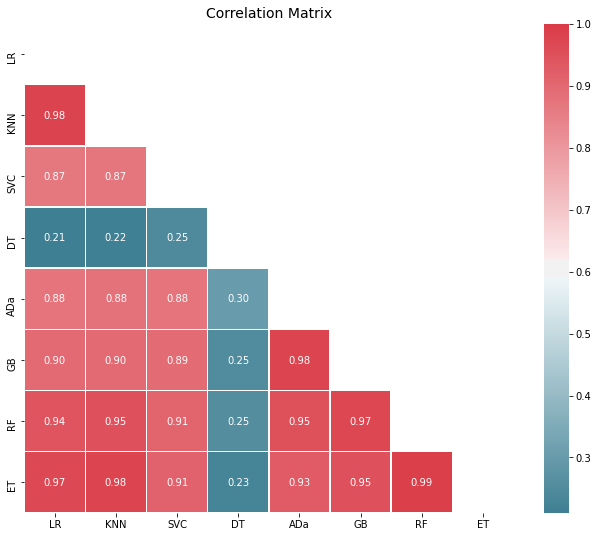

In [173]:
from mlens.visualization import corrmat

corrmat(P.corr(), inflate=False)

In [0]:
from sklearn.ensemble import GradientBoostingRegressor

In [0]:
base_learners = get_models()
meta_learner = GradientBoostingRegressor(
    n_estimators=1000,
    loss="huber", # also need to try ls
    max_features=6,
    max_depth=3,
    subsample=0.5,
    learning_rate=0.001, 
    random_state=10
)

In [0]:
from mlens.ensemble import SuperLearner

In [0]:
# cost function for base models
def rmse(yreal, yhat):
	return mse(yreal, yhat)**(0.5)

In [196]:
# Instantiate the ensemble with 10 folds
sl = SuperLearner(
    folds=10,
    random_state=10,
    verbose=2,
    backend="multiprocessing",
    scorer=rmse
)

# Add the base learners and the meta learner
sl.add(list(base_learners.values())) 
sl.add_meta(meta_learner)

# Train the ensemble
sl.fit(X_train_sc, y_train_sc)


Fitting 2 layers
Processing layer-1             done | 00:04:44
Processing layer-2             done | 00:00:06
Fit complete                        | 00:04:51


SuperLearner(array_check=None, backend=None, folds=10,
       layers=[Layer(backend='threading', dtype=<class 'numpy.float32'>, n_jobs=-1,
   name='layer-1', propagate_features=None, raise_on_exception=True,
   random_state=1289, shuffle=False,
   stack=[Group(backend='threading', dtype=<class 'numpy.float32'>,
   indexer=FoldIndex(X=None, folds=10, raise_on_e...750268>)],
   n_jobs=-1, name='group-13', raise_on_exception=True, transformers=[])],
   verbose=1)],
       model_selection=False, n_jobs=None, raise_on_exception=True,
       random_state=10, sample_size=20,
       scorer=<function rmse at 0x7f5ade750268>, shuffle=False, verbose=2)

In [198]:
p_sl = sl.predict(X_test_sc)


Predicting 2 layers
Processing layer-1             done | 00:00:00
Processing layer-2             done | 00:00:00
Predict complete                    | 00:00:01


In [200]:
print('prediction on test set is:' ,mse(y_test_sc,p_sl)**0.5)

prediction on test set is: 0.0439843382741155


In [269]:
scaler = StandardScaler()
scaler.fit(train[imp_cols])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [0]:
### Final model :)
param = {'metric': 'euclidean', 'n_neighbors': 2}
model2 = KNeighborsRegressor(**param)

In [271]:
model2.fit(scaler.transform(train[imp_cols]), Y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='euclidean',
                    metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                    weights='uniform')

In [0]:
X_test = scaler.transform(test[imp_cols])

In [0]:
y_pred = model2.predict(X_test)

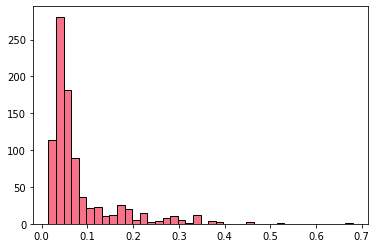

In [275]:
plt.hist(y_pred, bins=40, edgecolor='black');

In [0]:
test['y_pred'] = y_pred

### 3. Allocation

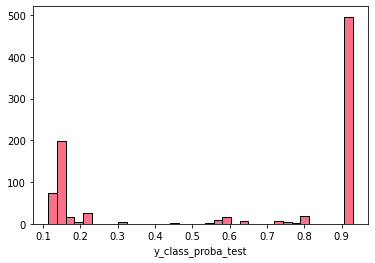

In [277]:
plt.hist(test['y_class_proba_test'], bins=35, edgecolor='black')
plt.xlabel('y_class_proba_test')
plt.show()

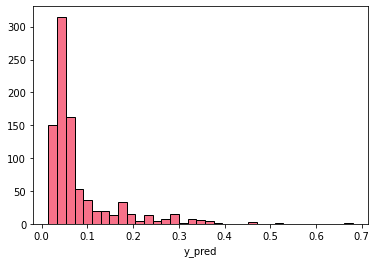

In [278]:
plt.hist(test['y_pred'], bins=35, edgecolor='black')
plt.xlabel('y_pred')
plt.show()

In [0]:
index = test.y_pred
pot_inc = -np.log(index+0.01)+3
p2= pot_inc**2/1000

In [0]:
submit = pd.DataFrame({
    'Index':test.index,
    'pred': test.y_pred,
    'opt_pred':0,
    'eei':test['existence expectancy index'], 
    'y_low_index_proba' : test['y_class_proba_test'],
})

In [0]:
submit.head()

,Index,pred,opt_pred,eei,y_low_index_proba
0,0,0.031897,0,0.456086,0.916728
1,1,0.032192,0,0.529835,0.916728
2,2,0.046337,0,0.560976,0.916728
3,3,0.042099,0,0.565910,0.916728
4,4,0.047627,0,0.588274,0.927679


In [0]:
THRESHOLD = 0.915
THRESHOLD_LOW = 0.7

In [0]:
num_sure = sum(y_class_proba_test[:,1] > THRESHOLD)
print(num_sure)

341


In [0]:
submit.loc[p2.nlargest(num_sure).index, 'opt_pred'] = 100

In [0]:
submit.loc[p2.nlargest(num_sure).index, ] 

,Index,pred,opt_pred,eei,y_low_index_proba
412,412,0.013212,100,0.934156,0.929483
72,72,0.014208,100,0.714260,0.911145
127,127,0.015181,100,0.768290,0.911145
14,14,0.016467,100,0.612233,0.927679
430,430,0.017283,100,0.939583,0.916728
...,...,...,...,...,...
74,74,0.047167,100,0.715798,0.921550
291,291,0.047188,100,0.873841,0.916728
385,385,0.047314,100,0.923537,0.914043
603,603,0.047333,100,1.000108,0.916728


In [0]:
DSML_left = 50000 - num_sure * 100

In [0]:
DSML_left

15900

In [0]:
print(num_sure)

341


In [0]:
condition = np.logical_and(submit.opt_pred != 100, y_class_proba_test[:,1] >= THRESHOLD_LOW)

In [0]:
sum(condition)

190

In [0]:
sum_y_low_index_proba=sum(submit.loc[condition,].y_low_index_proba)

In [0]:
sum_y_low_index_proba

170.3745408331888

In [0]:
submit.loc[condition,'opt_pred'] = submit.loc[condition,'y_low_index_proba'] / sum_y_low_index_proba * DSML_left - 0.00001

In [0]:
sum(submit.loc[condition,'opt_pred'])

15899.9981

In [0]:
increase = (submit['opt_pred']*p2)

In [0]:
print(sum(increase), submit.loc[submit.eei < 0.7, 'opt_pred'].sum(), submit['opt_pred'].sum())

1763.6826984688469 6456.521078368885 49999.99809999998


In [0]:
submit[['Index', 'pred', 'opt_pred']].to_csv('submission.csv', index=False)

In [0]:
##

### 3.1 Allocation

In [0]:
index = test.y_pred
pot_inc = -np.log(index+0.01)+3
p2= pot_inc**2

In [0]:
ss = pd.DataFrame({
    'Index':test.index,
    'pred': test.y_pred,
    'opt_pred':0,
    'eei':test['existence expectancy index'], 
    'prob': test['y_class_proba_test']
})

In [281]:
ss.loc[p2.nlargest(400).index, 'opt_pred']=100
ss=ss.sort_values('pred')
ss['opt_pred'].sum()

40000

In [0]:
DSML_left = 50000 - ss['opt_pred'].sum()

In [283]:
prob_sum = sum(ss.iloc[400:600,]['prob'])
prob_sum

149.1299061886067

In [0]:
right_indexes = ss.index
ss.reset_index(inplace=True)

In [0]:
ss.loc[400:599,'opt_pred'] = ss.loc[400:599].prob / prob_sum * DSML_left - 0.0000001

In [286]:
len(ss.loc[400:599])

200

In [287]:
sum(ss.loc[400:599].prob / prob_sum * DSML_left - 0.0000001)

9999.999980000011

In [288]:
ss.head()

,index,Index,pred,opt_pred,eei,prob
0,226,226,0.014944,100.0,0.837247,0.921550
1,147,147,0.014944,100.0,0.780565,0.921550
2,49,49,0.016447,100.0,0.671839,0.929483
3,34,34,0.019692,100.0,0.650696,0.916728
4,138,138,0.021095,100.0,0.775467,0.916728


In [289]:
ss.sort_values(by='index', inplace=True)
ss.head()

,index,Index,pred,opt_pred,eei,prob
351,0,0,0.046409,100.0,0.456086,0.916728
223,1,1,0.040470,100.0,0.529835,0.916728
334,2,2,0.045668,100.0,0.560976,0.916728
268,3,3,0.042622,100.0,0.565910,0.916728
157,4,4,0.034494,100.0,0.588274,0.927679


In [0]:
increase = (ss['opt_pred']*p2)/1000

In [292]:
print(sum(increase), ss.loc[ss.eei < 0.7, 'opt_pred'].sum(), ss['opt_pred'].sum())

1757.9939322489663 6469.247912709963 49999.999979999986


In [0]:
ss[['Index', 'pred', 'opt_pred']].to_csv('submission.csv', index=False)